In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import tqdm

### Define paths for the model and data of interest

In [2]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/binary/"
chrom_set = ["chr1"]
input_length = 1000

In [3]:
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/binary/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1/1/model_ckpt_epoch_10.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/1/model_ckpt_epoch_8.pt")

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Import the model without priors
noprior_model = model_util.restore_model(model_class, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device)

In [6]:
# Import the model with priors
prior_model = model_util.restore_model(model_class, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [7]:
input_func = data_loading.get_binary_input_func(
    files_spec_path, input_length, reference_fasta
)
pos_bins = data_loading.get_positive_binary_bins(
    files_spec_path, chrom_set=chrom_set
)

### Shap explainer
Create DeepSHAP explainers

In [8]:
noprior_shap_explainer = compute_shap.create_binary_explainer(
    noprior_model, input_length, num_tasks
)

In [9]:
prior_shap_explainer = compute_shap.create_binary_explainer(
    prior_model, input_length, num_tasks
)

### Plotting functions

In [10]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [11]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()
    plt.show()

### View predictions

In [12]:
def predict_and_plot(model, shap_explainer, bin_index, seq_slice=slice(450, 550)):
    true_vals, pred_vals, coords, input_grads, input_seqs = \
        compute_predictions.get_binary_model_predictions(
            model, np.array([bin_index]), input_func, return_gradients=True,
            show_progress=False
        )
    chrom, start, end = coords[0]
    print("%s:%d-%d" % (chrom, start, end))
    print("Input gradient shape and Fourier transform")
    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=200)
    
    print("Input gradients")
    viz_sequence.plot_weights(input_grads[0][seq_slice])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice])
    
    print("Shap scores")
    hyp_shap_scores = shap_explainer(
        input_seqs, hide_shap_output=True
    )
    viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice])
    viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice])
    
    print("ISM scores")
    hyp_ism_scores = compute_ism.get_binary_model_ism(
        model, input_seqs, slice_only=seq_slice
    )
    viz_sequence.plot_weights(hyp_ism_scores[0][seq_slice])
    viz_sequence.plot_weights((hyp_ism_scores[0] * input_seqs[0])[seq_slice])

In [13]:
# Sample some random peaks
pos_bins[np.random.choice(len(pos_bins), size=10, replace=False)]

array([ 438793, 1273876, 1105152, 2232310,  546433, 1325643, 4490059,
       3955655,  807462, 4532654])

chr1:28282800-28283800
Input gradient shape and Fourier transform


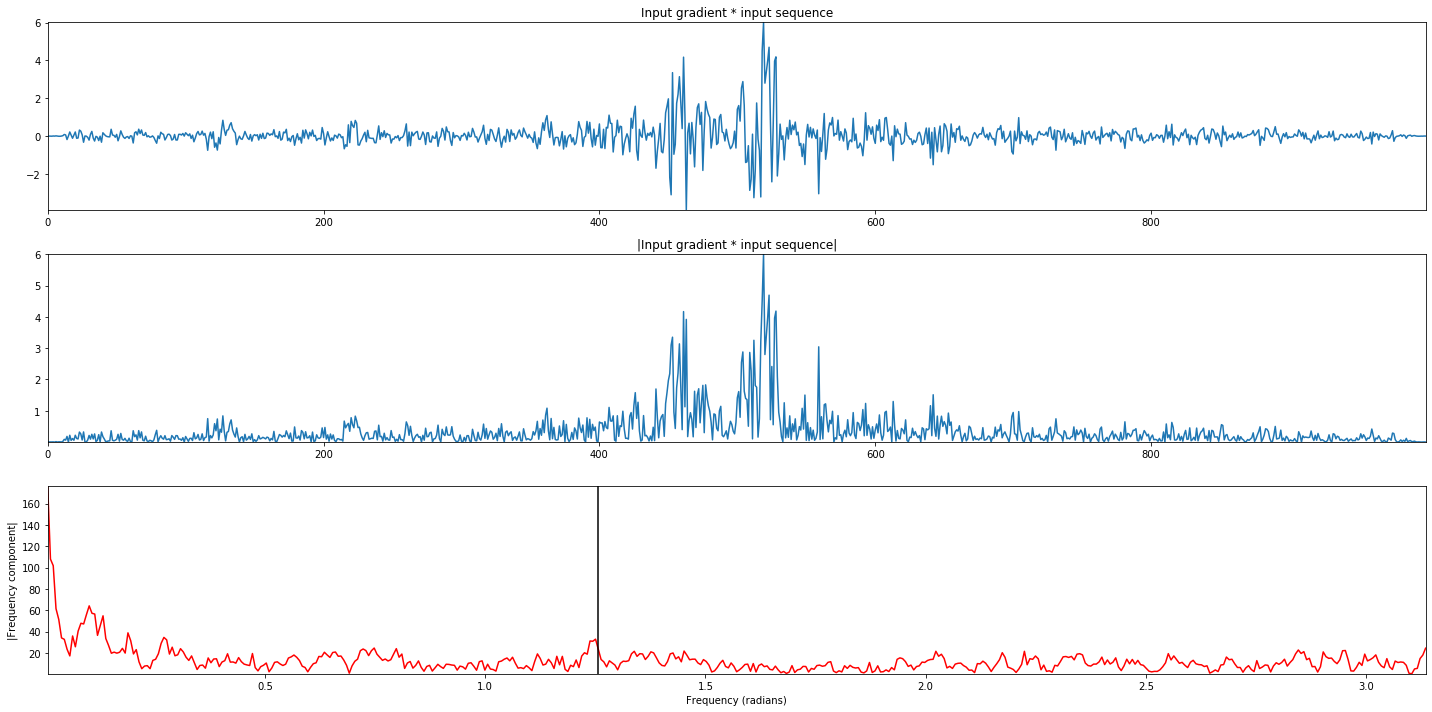

Input gradients


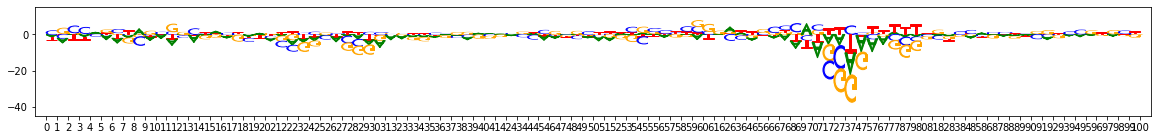

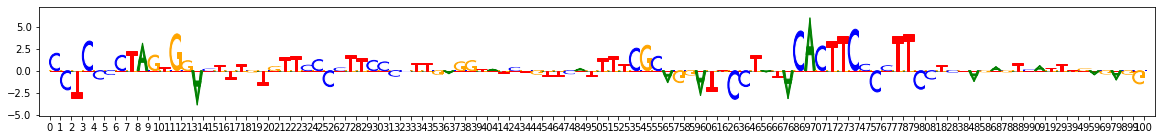

Shap scores


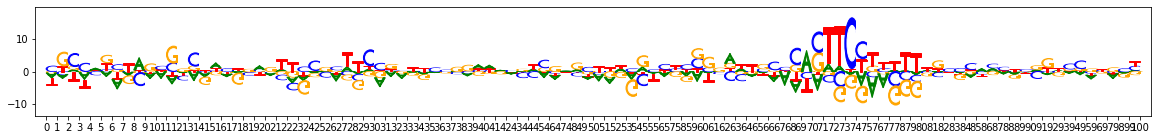

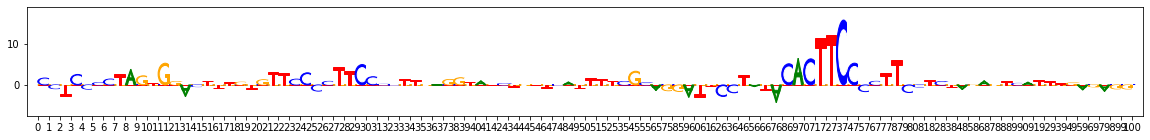

ISM scores


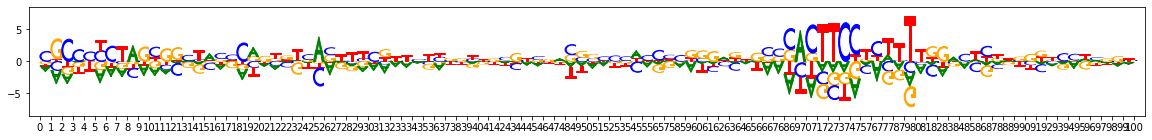

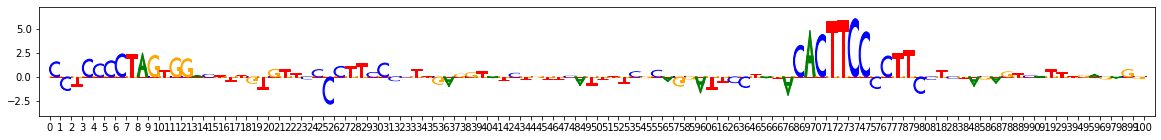

chr1:28282800-28283800
Input gradient shape and Fourier transform


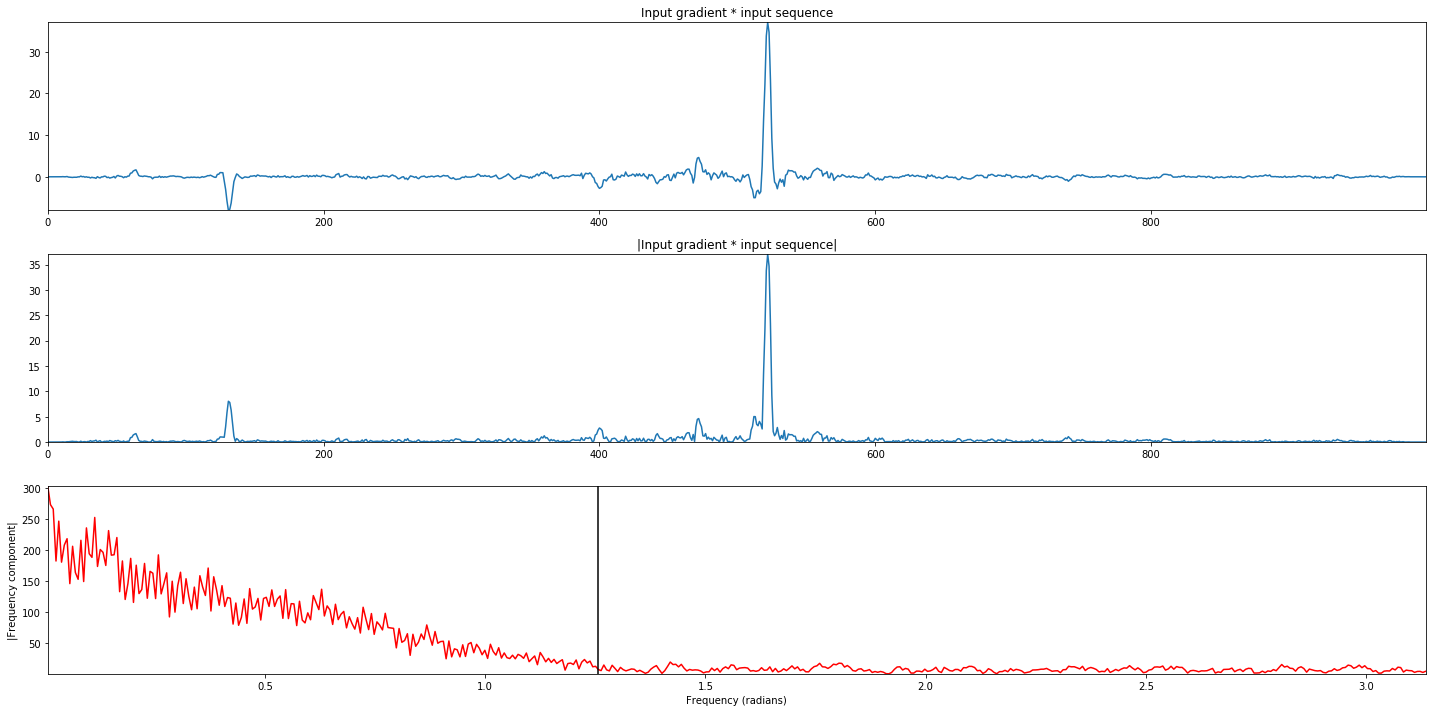

Input gradients


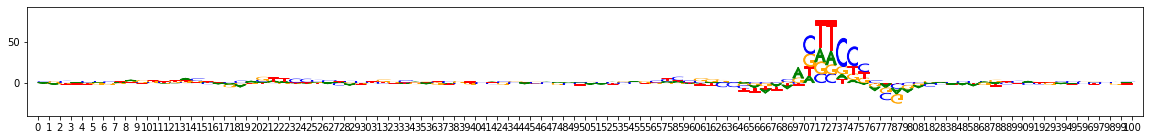

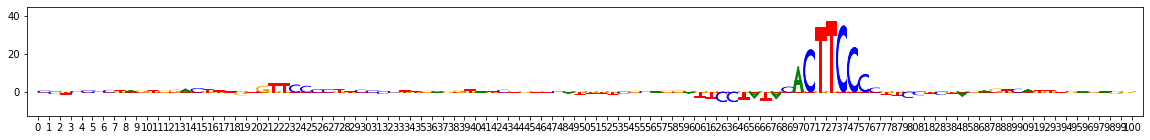

Shap scores


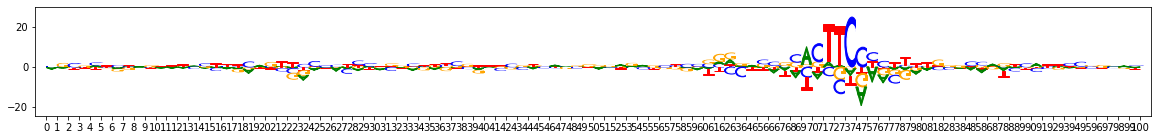

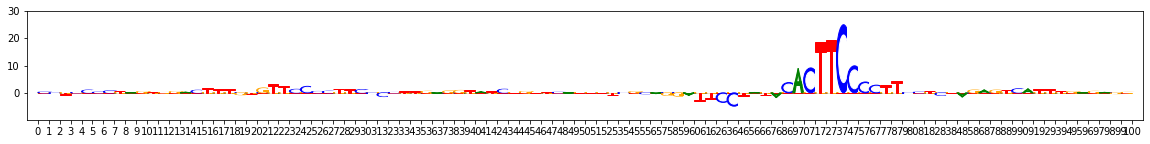

ISM scores


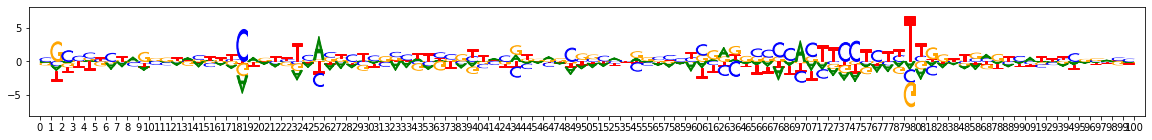

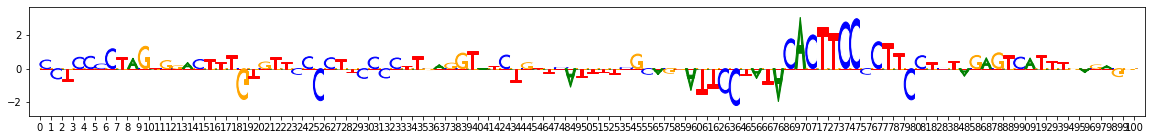

In [14]:
# SPI1
bin_index = 565656
seq_slice = slice(450, 550)
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, seq_slice)

chr1:53654400-53655400
Input gradient shape and Fourier transform


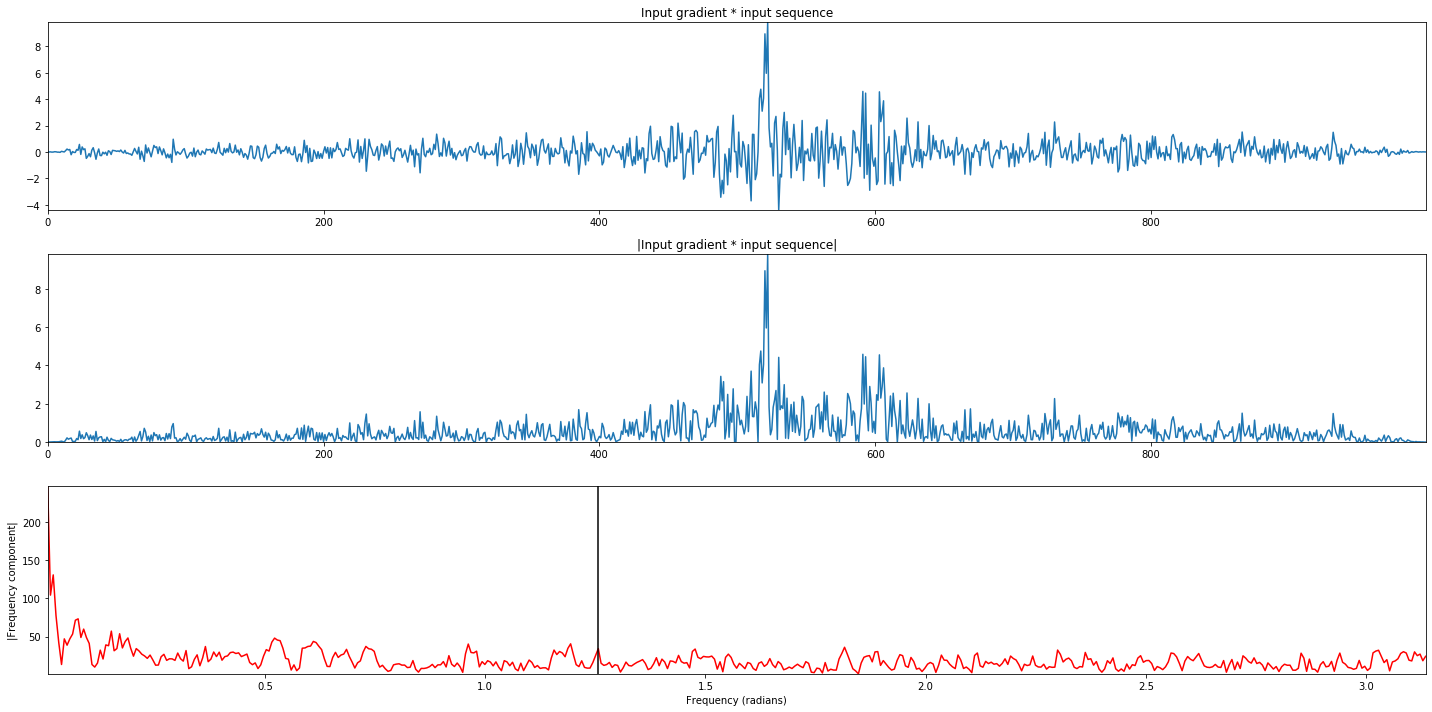

Input gradients


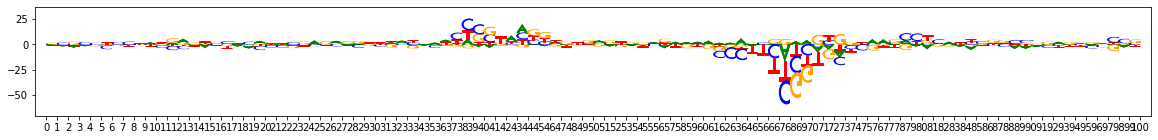

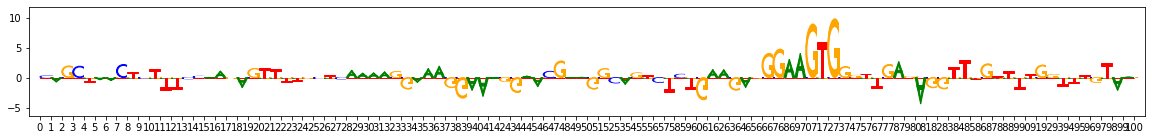

Shap scores


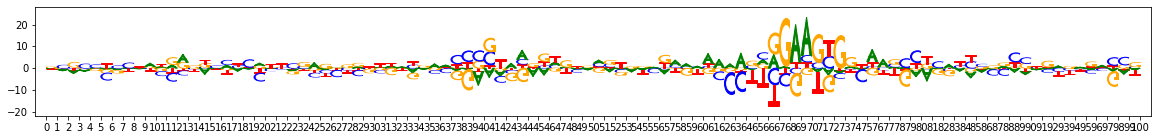

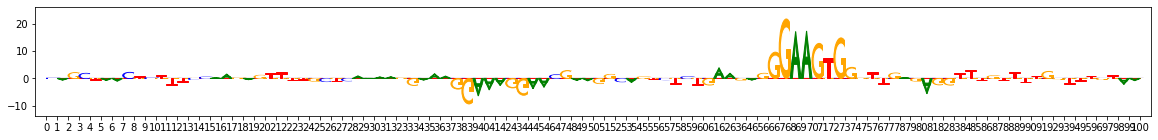

ISM scores


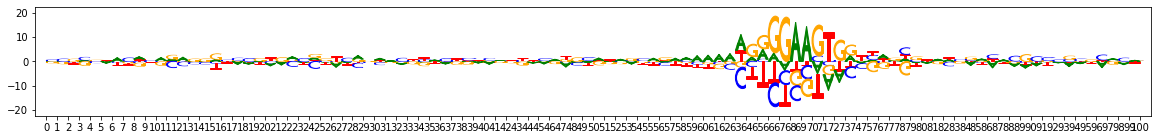

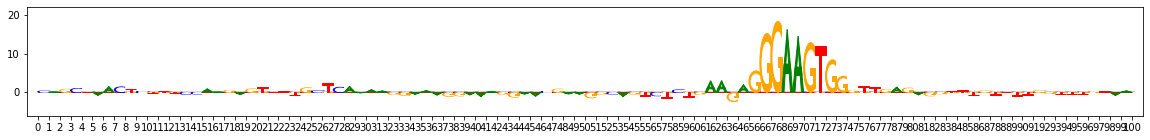

chr1:53654400-53655400
Input gradient shape and Fourier transform


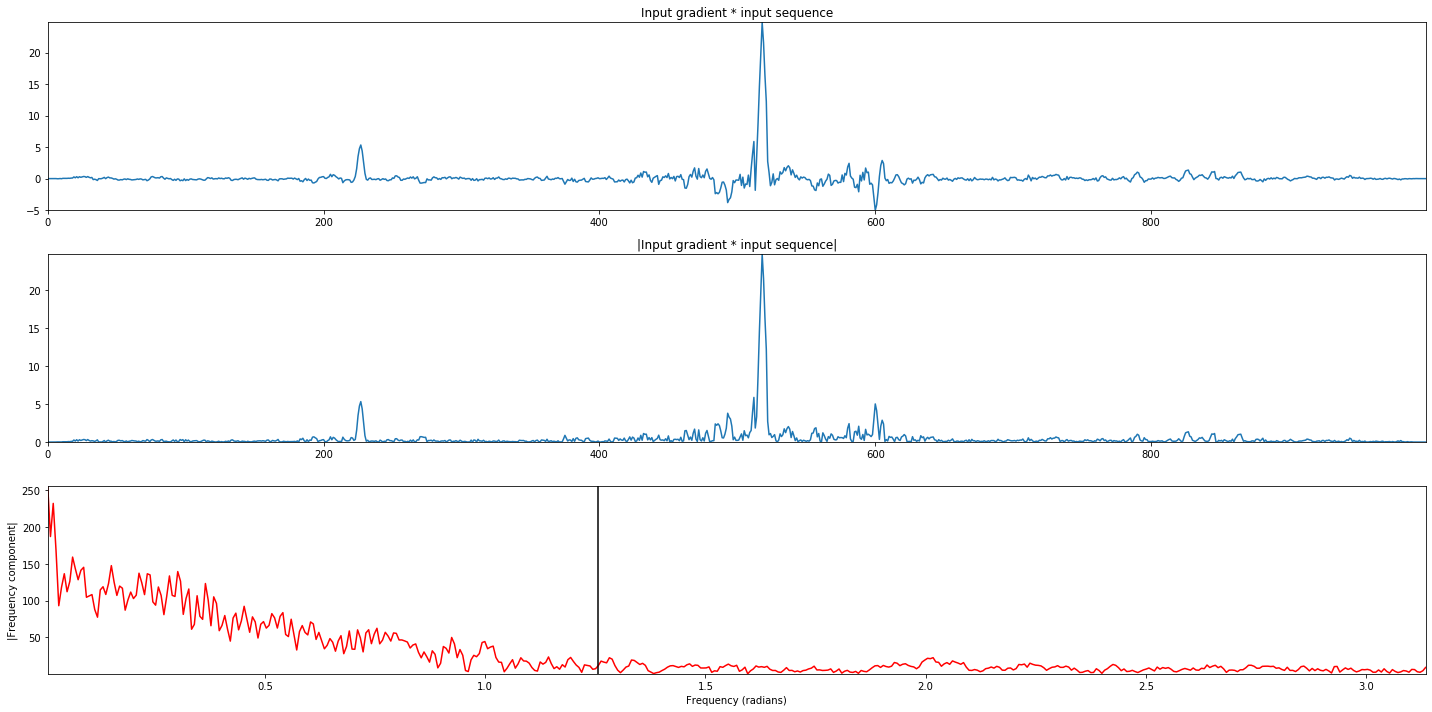

Input gradients


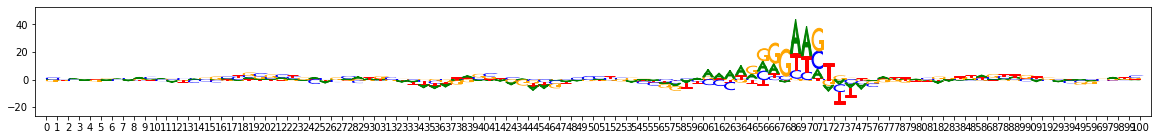

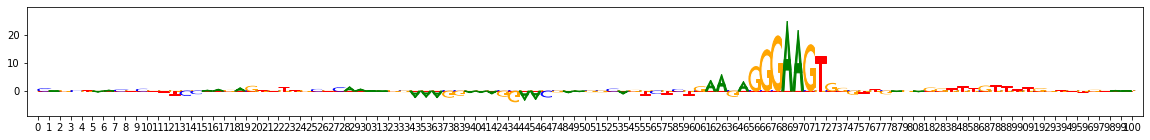

Shap scores


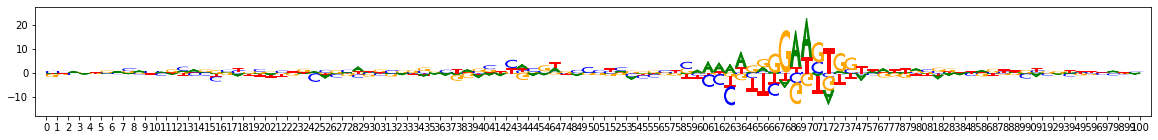

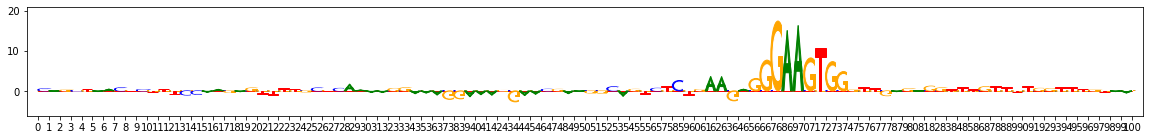

ISM scores


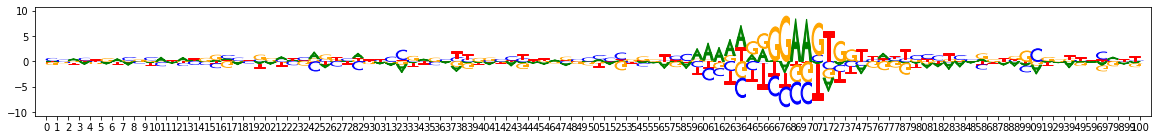

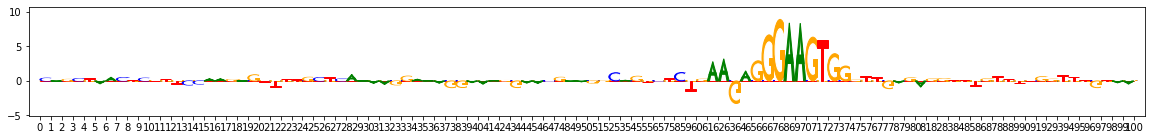

In [15]:
# SPI1
bin_index = 1073088
seq_slice = slice(450, 550)
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, seq_slice)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, seq_slice)